**Chapter 4 – Training Linear Models**

_This notebook contains all the sample code and solutions to the exercises in chapter 4._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml/blob/master/04_training_linear_models.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

**Warning**: this is the code for the 1st edition of the book. Please visit https://github.com/ageron/handson-ml2 for the 2nd edition code, with up-to-date notebooks using the latest library versions.

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [ ]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Linear regression using the Normal Equation

In [ ]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

In [ ]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

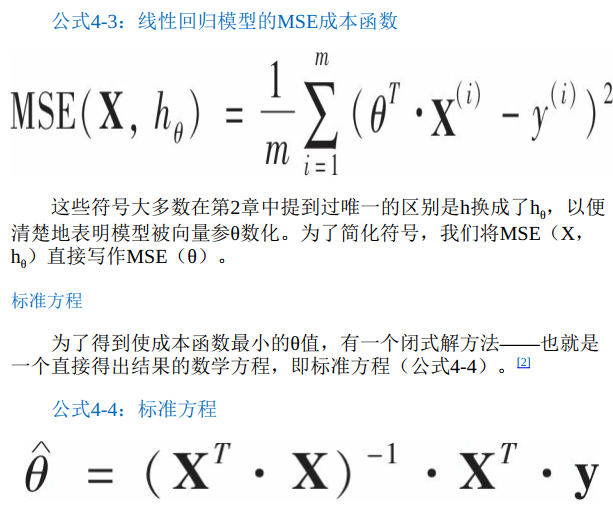

In [31]:
# np.r_是按列连接两个矩阵，就是把两矩阵上下相加，要求列数相等。
# np.c_是按行连接两个矩阵，就是把两矩阵左右相加，要求行数相等。
X_b = np.c_[np.ones((100, 1)), X]  # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [32]:
theta_best

array([[3.56401543],
       [0.84362064]])

In [33]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[3.56401543],
       [5.25125671]])

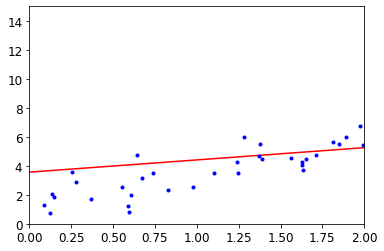

In [34]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

The figure in the book actually corresponds to the following code, with a legend and axis labels:

Saving figure linear_model_predictions


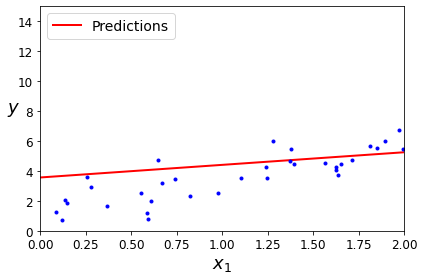

In [35]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
save_fig("linear_model_predictions")
plt.show()

In [36]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
# 偏置项（intercept_） 和特征权重（coef_） 
lin_reg.intercept_, lin_reg.coef_

(array([3.56401543]), array([[0.84362064]]))

In [37]:
lin_reg.predict(X_new)

array([[3.56401543],
       [5.25125671]])

The `LinearRegression` class is based on the `scipy.linalg.lstsq()` function (the name stands for "least squares"), which you could call directly:

In [38]:
# 最小二乘法
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[3.56401543],
       [0.84362064]])

This function computes $\mathbf{X}^+\mathbf{y}$, where $\mathbf{X}^{+}$ is the _pseudoinverse_ of $\mathbf{X}$ (specifically the Moore-Penrose inverse). You can use `np.linalg.pinv()` to compute the pseudoinverse directly:

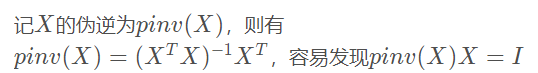

In [39]:
np.linalg.pinv(X_b).dot(y)

array([[3.56401543],
       [0.84362064]])

**Note**: the first releases of the book implied that the `LinearRegression` class was based on the Normal Equation. This was an error, my apologies: as explained above, it is based on the pseudoinverse, which ultimately relies on the SVD matrix decomposition of $\mathbf{X}$ (see chapter 8 for details about the SVD decomposition). Its time complexity is $O(n^2)$ and it works even when $m < n$ or when some features are linear combinations of other features (in these cases, $\mathbf{X}^T \mathbf{X}$ is not invertible so the Normal Equation fails), see [issue #184](https://github.com/ageron/handson-ml/issues/184) for more details. However, this does not change the rest of the description of the `LinearRegression` class, in particular, it is based on an analytical solution, it does not scale well with the number of features, it scales linearly with the number of instances, all the data must fit in memory, it does not require feature scaling and the order of the instances in the training set does not matter.

# Linear regression using batch gradient descent

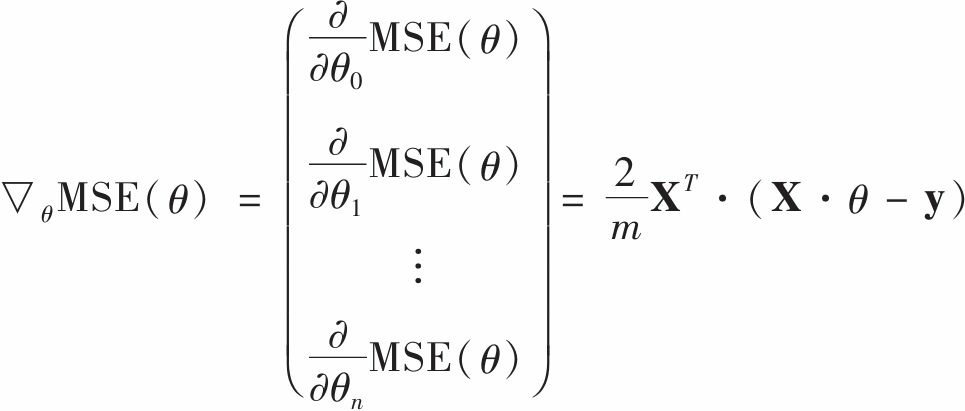

In [40]:
eta = 0.1
n_iterations = 1000
m = 100
theta = np.random.randn(2,1)

for iteration in range(n_iterations):
#     计算梯度
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [41]:
theta

array([[3.56401543],
       [0.84362064]])

In [42]:
# 预测
X_new_b.dot(theta)

array([[3.56401543],
       [5.25125671]])

In [43]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
#             预测值
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
#         绘制点
            plt.plot(X_new, y_predict, style)
#             梯度
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
#     梯度下降
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

<ipython-input-43-5c31d01582af>:17: RuntimeWarning: invalid value encountered in subtract
  theta = theta - eta * gradients


Saving figure gradient_descent_plot


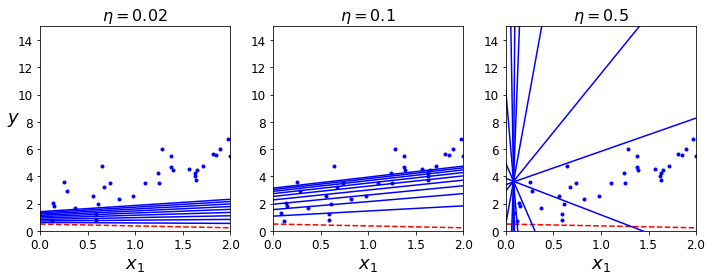

In [44]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

save_fig("gradient_descent_plot")
plt.show()

# Stochastic Gradient Descent

In [47]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

Saving figure sgd_plot


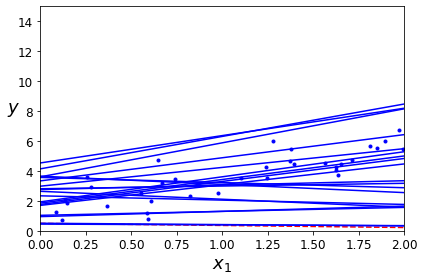

In [48]:
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:  
#             预测并绘图
            # not shown in the book
            y_predict = X_new_b.dot(theta)           # not shown
            style = "b-" if i > 0 else "r--"         # not shown
            plt.plot(X_new, y_predict, style)        # not shown
#             随机选择数据
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
#         梯度
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
#         学习计划
        eta = learning_schedule(epoch * m + i)
#     theta值
        theta = theta - eta * gradients
#     添加
        theta_path_sgd.append(theta)                 # not shown

plt.plot(X, y, "b.")                                 # not shown
plt.xlabel("$x_1$", fontsize=18)                     # not shown
plt.ylabel("$y$", rotation=0, fontsize=18)           # not shown
plt.axis([0, 2, 0, 15])                              # not shown
save_fig("sgd_plot")                                 # not shown
plt.show()                                           # not shown

In [49]:
theta

array([[3.5438526 ],
       [0.79597568]])

In [50]:
# 随机梯度下降回归
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=50, tol=-np.infty, penalty=None, eta0=0.1, random_state=42)
# 扁平化操作
# 这两个函数实现的功能一样,但我们在平时使用的时候flatten()更为合适.在使用过程中flatten()分配了新的内存,
# 但ravel()返回的是一个数组的视图.
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, max_iter=50, penalty=None, random_state=42, tol=-inf)

In [51]:
# 偏置项（intercept_） 和特征权重（coef_） 
sgd_reg.intercept_, sgd_reg.coef_

(array([3.54679613]), array([0.972775]))

# Mini-batch gradient descent

In [52]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

t0, t1 = 200, 1000
# 随时间增加 学习系数变小
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
#     随机排序
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
#         小批量
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
#         计算梯度
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
#     学习率
        eta = learning_schedule(t)
#     theta值
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [53]:
theta

array([[3.67597088],
       [0.86943555]])

In [54]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

Saving figure gradient_descent_paths_plot


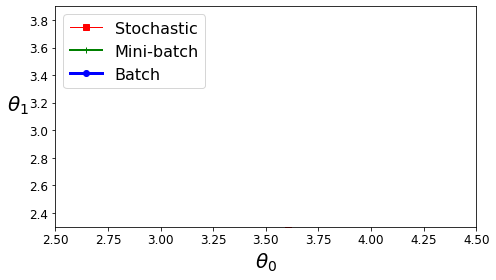

In [55]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
save_fig("gradient_descent_paths_plot")
plt.show()

# Polynomial regression

In [56]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)

In [57]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

Saving figure quadratic_data_plot


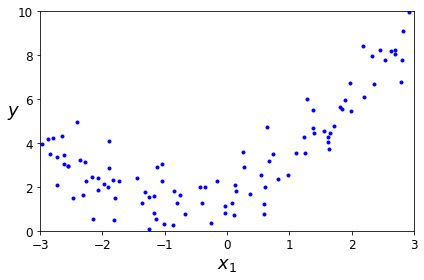

In [58]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_data_plot")
plt.show()

In [61]:
from sklearn.preprocessing import PolynomialFeatures
# 多项式回归
# PolynomialFeatures 这个类有 3 个参数：
# degree：控制多项式的次数；
# interaction_only：默认为 False，如果指定为 True，那么就不会有特征自己和自己结合的项，组合的特征中没有 a2 和 b2；
# include_bias：默认为 True 。如果为 True 的话，那么结果中就会有 0 次幂项，即全为 1 这一列。
poly_features = PolynomialFeatures(degree=2, include_bias=False)
# 拟合
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [62]:
X_poly[0]

array([-0.75275929,  0.56664654])

In [63]:
X_poly

array([[-7.52759287e-01,  5.66646544e-01],
       [ 2.70428584e+00,  7.31316190e+00],
       [ 1.39196365e+00,  1.93756281e+00],
       [ 5.91950905e-01,  3.50405874e-01],
       [-2.06388816e+00,  4.25963433e+00],
       [-2.06403288e+00,  4.26023172e+00],
       [-2.65149833e+00,  7.03044338e+00],
       [ 2.19705687e+00,  4.82705891e+00],
       [ 6.06690070e-01,  3.68072842e-01],
       [ 1.24843547e+00,  1.55859111e+00],
       [-2.87649303e+00,  8.27421218e+00],
       [ 2.81945911e+00,  7.94934969e+00],
       [ 1.99465584e+00,  3.97865194e+00],
       [-1.72596534e+00,  2.97895634e+00],
       [-1.90905020e+00,  3.64447265e+00],
       [-1.89957294e+00,  3.60837736e+00],
       [-1.17454654e+00,  1.37955958e+00],
       [ 1.48538590e-01,  2.20637127e-02],
       [-4.08329888e-01,  1.66733298e-01],
       [-1.25262516e+00,  1.56906979e+00],
       [ 6.71117368e-01,  4.50398522e-01],
       [-2.16303684e+00,  4.67872835e+00],
       [-1.24713211e+00,  1.55533850e+00],
       [-8.

In [64]:
# 线性拟合
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
# 偏移量 系数
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

Saving figure quadratic_predictions_plot


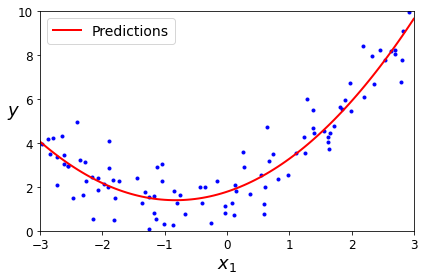

In [65]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
# 多次项拟合
X_new_poly = poly_features.transform(X_new)
# 线性回归预测
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_predictions_plot")
plt.show()

Saving figure high_degree_polynomials_plot


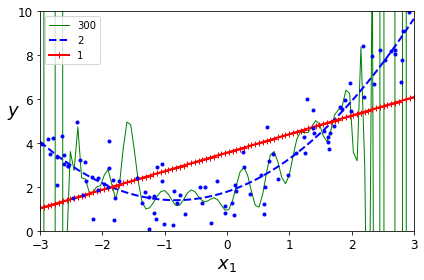

In [66]:
from sklearn.preprocessing import StandardScaler
# 标准化缩放
from sklearn.pipeline import Pipeline
# 管道

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
#     多项式
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
#     缩放
    std_scaler = StandardScaler()
#     线性回归
    lin_reg = LinearRegression()
#     管道
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
#     训练
    polynomial_regression.fit(X, y)
#     预测
    y_newbig = polynomial_regression.predict(X_new)
#     绘制
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("high_degree_polynomials_plot")
plt.show()

In [67]:
# 度量
from sklearn.metrics import mean_squared_error
# 训练 测试集分割
from sklearn.model_selection import train_test_split

# 使用不同大小的训练集训练模型，生成误差曲线 
def plot_learning_curves(model, X, y):
#   训练 测试集分割
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
#         训练
        model.fit(X_train[:m], y_train[:m])
#     训练集预测
        y_train_predict = model.predict(X_train[:m])
#     测试集预测
        y_val_predict = model.predict(X_val)
#     训练集误差
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
#     测试集误差
        val_errors.append(mean_squared_error(y_val, y_val_predict))
# 绘制
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

Saving figure underfitting_learning_curves_plot


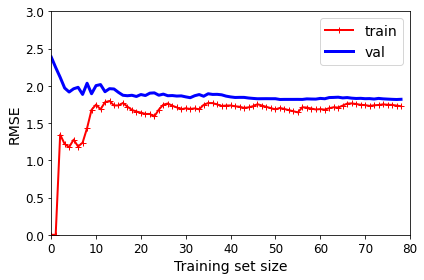

In [68]:
# 线性回归
lin_reg = LinearRegression()
# 绘制学习曲线
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                         # not shown in the book
save_fig("underfitting_learning_curves_plot")   # not shown
plt.show()                                      # not shown

Saving figure learning_curves_plot


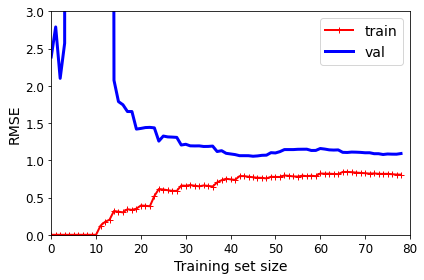

In [69]:
from sklearn.pipeline import Pipeline
# 使用管道
polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])
# 绘制学习曲线
plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])           # not shown
save_fig("learning_curves_plot")  # not shown
plt.show()                        # not shown

# Regularized models

岭回归成本函数
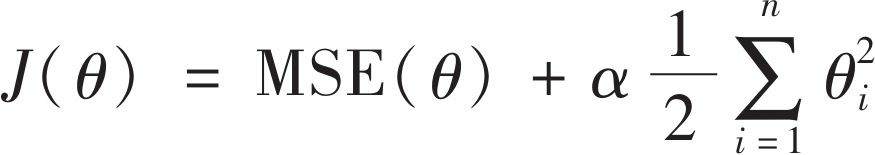

Saving figure ridge_regression_plot


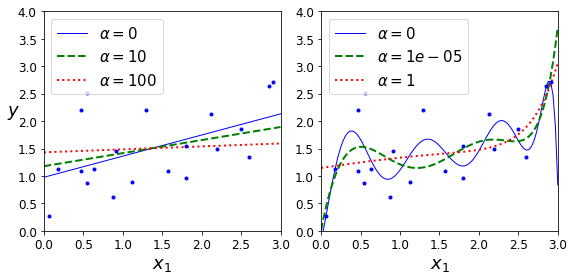

In [73]:
from sklearn.linear_model import Ridge
"""
岭回归 : 线性回归的正则化版
正则项只能在训练的时候添加到成本函数中，一旦训练完成，你需要使用未经正则化的性能指标来评估模型性能
超参数α控制的是对模型进行正则化的程度。如果α=0，则岭回归就是线性模型。如果α非常大，
那么所有的权重都将非常接近于零，结果是一条穿过数据平均值的水平线。

sklearn.linear_model.Ridge()函数是具有l2正则化的线性最小二乘法。
class sklearn.linear_model.Ridge(alpha=1.0, fit_intercept=True, normalize=False, 
    copy_X=True, max_iter=None, tol=0.001, solver=’auto’, random_state=None)

参数：
alpha：正则化系数，float类型，默认为1.0。正则化改善了问题的条件并减少了估计的方差。较大的值指定较强的正则化。
fit_intercept：是否需要截距，bool类型，默认为True。也就是是否求解b。
normalize：是否先进行归一化，bool类型，默认为False。如果为真，则回归X将在回归之前被归一化。 当fit_intercept设置为False时，将忽略此参数。 当回归量归一化时，注意到这使得超参数学习更加鲁棒，并且几乎不依赖于样本的数量。 相同的属性对标准化数据无效。然而，如果你想标准化，请在调用normalize = False训练估计器之前，使用preprocessing.StandardScaler处理数据。
copy_X：是否复制X数组，bool类型，默认为True，如果为True，将复制X数组; 否则，它覆盖原数组X。
max_iter：最大的迭代次数，int类型，默认为None，最大的迭代次数，对于sparse_cg和lsqr而言，默认次数取决于scipy.sparse.linalg，对于sag而言，则默认为1000次。
tol：精度，float类型，默认为0.001。就是解的精度。
solver：求解方法，str类型，默认为auto。可选参数为：auto、svd、cholesky、lsqr、sparse_cg、sag。
auto根据数据类型自动选择求解器。
svd使用X的奇异值分解来计算Ridge系数。对于奇异矩阵比cholesky更稳定。
cholesky使用标准的scipy.linalg.solve函数来获得闭合形式的解。
sparse_cg使用在scipy.sparse.linalg.cg中找到的共轭梯度求解器。作为迭代算法，这个求解器比大规模数据（设置tol和max_iter的可能性）的cholesky更合适。
lsqr使用专用的正则化最小二乘常数scipy.sparse.linalg.lsqr。它是最快的，但可能在旧的scipy版本不可用。它是使用迭代过程。
sag使用随机平均梯度下降。它也使用迭代过程，并且当n_samples和n_feature都很大时，通常比其他求解器更快。注意，sag快速收敛仅在具有近似相同尺度的特征上被保证。您可以使用sklearn.preprocessing的缩放器预处理数据。
random_state：sag的伪随机种子。
"""

np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
# 岭回归
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
# 岭回归 + 多项式回归
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

save_fig("ridge_regression_plot")
plt.show()

闭式解的岭回归
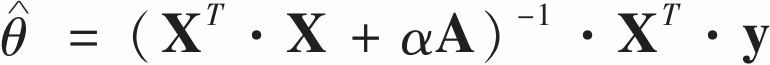

In [74]:
from sklearn.linear_model import Ridge
# 闭式解的岭回归 : 利用André-Louis Cholesky的矩阵因式分解法
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
# 训练
ridge_reg.fit(X, y)
# 预测
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [76]:
# 随机梯度下降回归
# 超参数penalty设置的是使用正则项的类型。 设为"l2"表示希望SGD在成本函数中添加一个正则项，
# 等于权重向量的l2范数的平方的一半， 即岭回归。
sgd_reg = SGDRegressor(max_iter=50, tol=-np.infty, penalty="l2", random_state=42)
# 训练
sgd_reg.fit(X, y.ravel())
# 预测
sgd_reg.predict([[1.5]])

array([1.49905184])

In [78]:
# 采用sag解法
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.5507201]])

Lasso回归成本函数
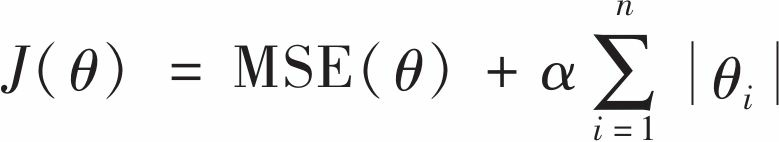
线性回归的另一种正则化， 叫作最小绝对收缩和选择算子回归（Least Absolute Shrinkage and Selection Operator Regression， 简称Lasso回归， 或套索回归）。与岭回归一样， 它也是向成本函数增加一个正则项， 但是它增加的是权重向量的l1范数， 而不是l2范数的平方的一半。
Lasso回归的一个重要特点是它倾向于完全消除掉最不重要特征的权重。

Saving figure lasso_regression_plot


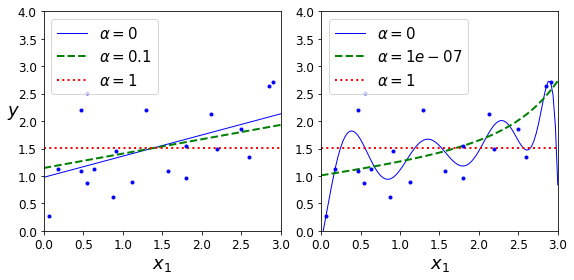

In [80]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), tol=1, random_state=42)

save_fig("lasso_regression_plot")
plt.show()

In [82]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

弹性网络成本函数
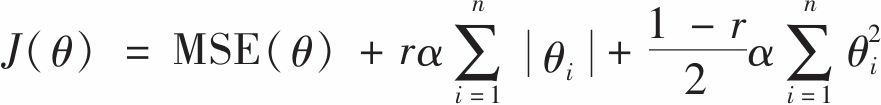

In [85]:
from sklearn.linear_model import ElasticNet
"""
弹性网络是岭回归与Lasso回归之间的中间地带。其正则项就是岭回归和Lasso回归的正则项的混合，混合比例通过r来控制。
当r＝0时，弹性网络即等同于岭回归，而当r＝1时，即相当于Lasso回归

岭回归是个不错的默认选择，但是如果你觉得实际用到的特征只有少数几个，那就应该更倾向于Lasso回归或是弹性网络，
因为它们会将无用特征的权重降为零。一般而言，弹性网络优于Lasso回归，因为当特征数量超过训练实例数量，
又或者是几个特征强相关时， Lasso回归的表现可能非常不稳定
"""
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

Saving figure early_stopping_plot


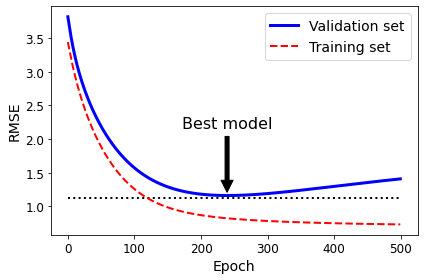

In [89]:
# 生成数据
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

# 分割训练集和测试集
X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

# 多项式回归 缩放
poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler()),
    ])

# 训练 转换
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
# 转换
X_val_poly_scaled = poly_scaler.transform(X_val)

# 随机下降回归
sgd_reg = SGDRegressor(max_iter=1,
                       tol=-np.infty,
                       penalty=None,
                       eta0=0.0005,
                       warm_start=True,
                       learning_rate="constant",
                       random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
#     训练
    sgd_reg.fit(X_train_poly_scaled, y_train)
#     训练集
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
#     测试集
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
#     误差
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))
# 
best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

"""
Axes.annotate(s, xy, *args, **kwargs)
s：注释文本的内容
xy：被注释的坐标点，二维元组形如(x,y)
xytext：注释文本的坐标点，也是二维元组，默认与xy相同
xycoords：被注释点的坐标系属性，允许输入的值如下
"""
plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )
# 绘制
best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
save_fig("early_stopping_plot")
plt.show()

In [92]:
from sklearn.base import clone
# 随机梯度下降回归
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True, penalty=None,
                       learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
#     训练
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
#     预测
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
#     评估
    val_error = mean_squared_error(y_val, y_val_predict)
#     记录最优结果
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

In [93]:
best_epoch, best_model

(239,
 SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
              random_state=42, tol=-inf, warm_start=True))

In [94]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

# ignoring bias term
t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[-1, 1], [-0.3, -1], [1, 0.1]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

Saving figure lasso_vs_ridge_plot


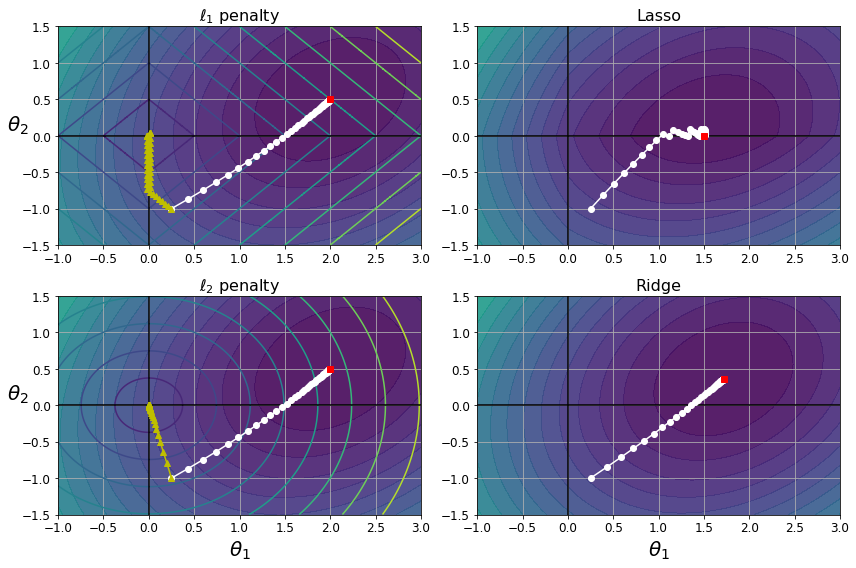

In [95]:
def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.1, n_iterations = 50):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + 2 * l2 * theta

        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

plt.figure(figsize=(12, 8))
for i, N, l1, l2, title in ((0, N1, 0.5, 0, "Lasso"), (1, N2, 0,  0.1, "Ridge")):
    JR = J + l1 * N1 + l2 * N2**2
    
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levelsJ=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN=np.linspace(0, np.max(N), 10)
    
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(t_init, Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)

    plt.subplot(221 + i * 2)
    plt.grid(True)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.contourf(t1, t2, J, levels=levelsJ, alpha=0.9)
    plt.contour(t1, t2, N, levels=levelsN)
    plt.plot(path_J[:, 0], path_J[:, 1], "w-o")
    plt.plot(path_N[:, 0], path_N[:, 1], "y-^")
    plt.plot(t1_min, t2_min, "rs")
    plt.title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    plt.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        plt.xlabel(r"$\theta_1$", fontsize=20)
    plt.ylabel(r"$\theta_2$", fontsize=20, rotation=0)

    plt.subplot(222 + i * 2)
    plt.grid(True)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    plt.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    plt.plot(t1r_min, t2r_min, "rs")
    plt.title(title, fontsize=16)
    plt.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        plt.xlabel(r"$\theta_1$", fontsize=20)

save_fig("lasso_vs_ridge_plot")
plt.show()

# Logistic regression

Saving figure logistic_function_plot


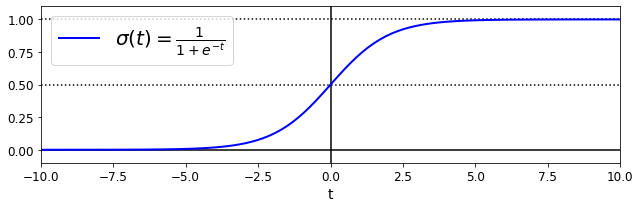

In [96]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
save_fig("logistic_function_plot")
plt.show()

In [98]:
from sklearn import datasets
# 加载数据
iris = datasets.load_iris()
# 列出键值
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [ ]:
print(iris.DESCR)

In [99]:
X = iris["data"][:, 3:]  # petal width
y = (iris["target"] == 2).astype(np.int)  # 1 if Iris-Virginica, else 0

<ipython-input-99-e0b44b550396>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = (iris["target"] == 2).astype(np.int)  # 1 if Iris-Virginica, else 0


In [101]:
from sklearn.linear_model import LogisticRegression
# 逻辑回归
log_reg = LogisticRegression(solver="liblinear", random_state=42)
log_reg.fit(X, y)

LogisticRegression(random_state=42, solver='liblinear')

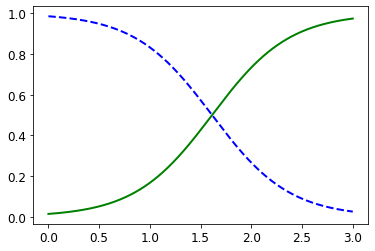

In [102]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris-Virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris-Virginica")

The figure in the book actually is actually a bit fancier:

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\patches.py:1338: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  verts = np.dot(coords, M) + (x + dx, y + dy)


Saving figure logistic_regression_plot


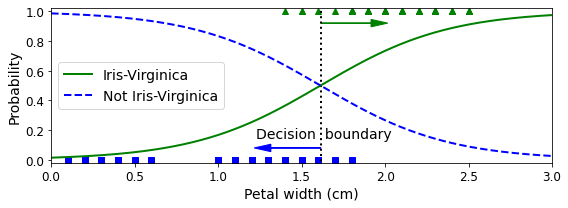

In [107]:
# 数据
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
# 预测
y_proba = log_reg.predict_proba(X_new)
# 边界
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
# 部分数据判断结果
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
# 绘制边界线
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
# 绘制两条预测线
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris-Virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris-Virginica")
# 绘制文字
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
# 绘制箭头
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
# 轴标签
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
# 图例
plt.legend(loc="center left", fontsize=14)
# 图幅大小
plt.axis([0, 3, -0.02, 1.02])
save_fig("logistic_regression_plot")
plt.show()

In [104]:
decision_boundary

array([1.61561562])

In [106]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

<ipython-input-109-43f81f9644fa>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = (iris["target"] == 2).astype(np.int)


Saving figure logistic_regression_contour_plot


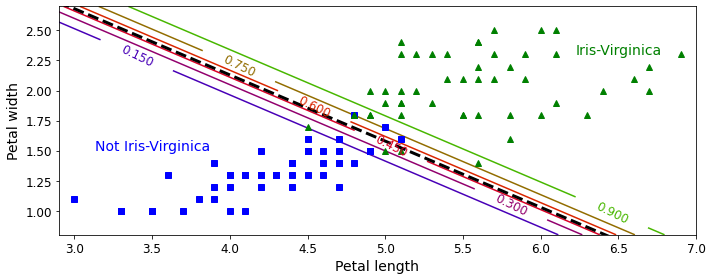

In [109]:
from sklearn.linear_model import LogisticRegression
# 加载数据
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)
# 训练
log_reg = LogisticRegression(solver="liblinear", C=10**10, random_state=42)
log_reg.fit(X, y)
# 网格化
x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
# 新数据集
X_new = np.c_[x0.ravel(), x1.ravel()]
# 预测
y_proba = log_reg.predict_proba(X_new)
# 绘图
plt.figure(figsize=(10, 4))
# 绘制数据
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")
# 取其中一个预测值
zz = y_proba[:, 1].reshape(x0.shape)
# 绘制等高线图
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)

# 横轴值
left_right = np.array([2.9, 7])
# 边界线方程： θ0+θ1x1+θ2x2=0
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]
# 參數：
# CS:要標記的ContourSet。
# levels:級別值列表，應標記出來。該列表必須是CS.levels的子集。如果未給出，則標記所有級別。它是一個可選參數(默認值為None)。
# fontsize:以磅為單位的尺寸或相對尺寸，例如‘smaller’，“ x-large”。有關可接受的字符串值，請參見Text.set_size。
# colors:標簽顏色-
# 如果為無，則每個標簽的顏色與相應輪廓的顏色匹配。
# 如果使用一種字符串顏色(例如，顏色= ‘r’或顏色= ‘red’)，則所有標簽都將以此顏色繪製。
# 如果是matplotlib顏色args(字符串，float，rgb等)的元組，則將按照指定的順序以不同的顏色繪製不同的標簽。
plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris-Virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris-Virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
save_fig("logistic_regression_contour_plot")
plt.show()

Softmax回归：
对于一个给定的实例x， Softmax回归模型首先计算出每个类别k的分数sk（x）， 
然后对这些分数应用softmax函数（也叫归一化指数） ， 估算出每个类别的概率。 
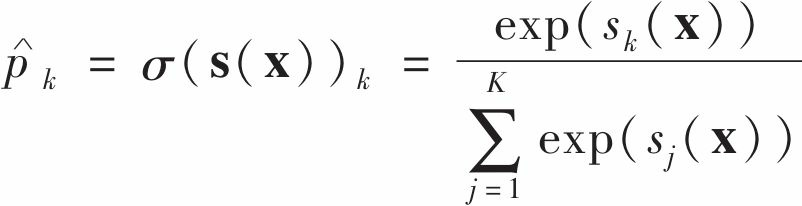

In [111]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]
# 将超参数multi_class设置为"multinomial"， 可以将其切换成Softmax回归
softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial', random_state=42)

Saving figure softmax_regression_contour_plot


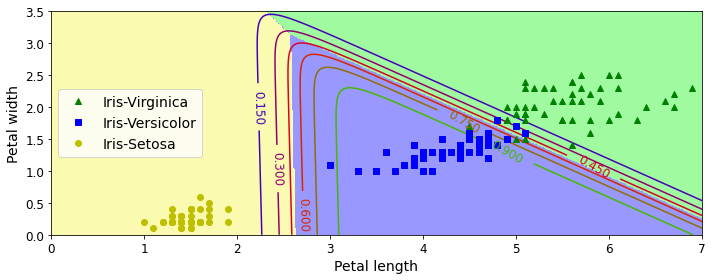

In [119]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
# 新数据
X_new = np.c_[x0.ravel(), x1.ravel()]

# 预测概率
y_proba = softmax_reg.predict_proba(X_new)
# 预测
y_predict = softmax_reg.predict(X_new)

# 概率
zz1 = y_proba[:, 1].reshape(x0.shape)
# 预测值
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
# 绘制数据结果
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

from matplotlib.colors import ListedColormap
"""
参数：
颜色：它是Matplotlib颜色规格的数组或列表，或等于N x 3或N x 4浮点数组(N rgb或rgba值)
名称：它是一个可选参数，它接受一个字符串来标识颜色图。
N:它是一个可选参数，它接受表示映射中条目数的整数值。
它的默认值为“无”，其中颜色列表中的每个元素都有一个颜色表条目。
如果N小于len(colors)，则列表将在N处截断，而如果N大于len，则列表将重复进行扩展。
"""
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
# 等高线图： contour() 是绘制轮廓线，contourf()会填充轮廓
plt.contourf(x0, x1, zz, cmap=custom_cmap)
# 绘制等高线图
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
# 绘制标签
plt.clabel(contour, inline=1, fontsize=12)
# 绘制坐标轴和图例
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
save_fig("softmax_regression_contour_plot")
plt.show()

In [113]:
softmax_reg.predict([[5, 2]])

array([2])

In [114]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

# Exercise solutions

## 1. to 11.

See appendix A.

## 12. Batch Gradient Descent with early stopping for Softmax Regression
(without using Scikit-Learn)

Let's start by loading the data. We will just reuse the Iris dataset we loaded earlier.

In [121]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

We need to add the bias term for every instance ($x_0 = 1$):

In [122]:
X_with_bias = np.c_[np.ones([len(X), 1]), X]

And let's set the random seed so the output of this exercise solution is reproducible:

In [123]:
np.random.seed(2042)

The easiest option to split the dataset into a training set, a validation set and a test set would be to use Scikit-Learn's `train_test_split()` function, but the point of this exercise is to try understand the algorithms by implementing them manually. So here is one possible implementation:

In [140]:
# 训练集 测试集 验证集
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

rnd_indices = np.random.permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

The targets are currently class indices (0, 1 or 2), but we need target class probabilities to train the Softmax Regression model. Each instance will have target class probabilities equal to 0.0 for all classes except for the target class which will have a probability of 1.0 (in other words, the vector of class probabilities for ay given instance is a one-hot vector). Let's write a small function to convert the vector of class indices into a matrix containing a one-hot vector for each instance:

In [141]:
# 独热编码
def to_one_hot(y):
    n_classes = y.max() + 1
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))
    Y_one_hot[np.arange(m), y] = 1
    return Y_one_hot

Let's test this function on the first 10 instances:

In [126]:
y_train[:10]

array([0, 1, 2, 1, 1, 0, 1, 1, 1, 0])

In [127]:
to_one_hot(y_train[:10])

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

Looks good, so let's create the target class probabilities matrix for the training set and the test set:

In [142]:
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

Now let's implement the Softmax function. Recall that it is defined by the following equation:

$\sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}$

In [143]:
# softmax算法
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums

We are almost ready to start training. Let's define the number of inputs and outputs:

In [130]:
n_inputs = X_train.shape[1] # == 3 (2 features plus the bias term)
n_outputs = len(np.unique(y_train))   # == 3 (3 iris classes)

Now here comes the hardest part: training! Theoretically, it's simple: it's just a matter of translating the math equations into Python code. But in practice, it can be quite tricky: in particular, it's easy to mix up the order of the terms, or the indices. You can even end up with code that looks like it's working but is actually not computing exactly the right thing. When unsure, you should write down the shape of each term in the equation and make sure the corresponding terms in your code match closely. It can also help to evaluate each term independently and print them out. The good news it that you won't have to do this everyday, since all this is well implemented by Scikit-Learn, but it will help you understand what's going on under the hood.

So the equations we will need are the cost function:

$J(\mathbf{\Theta}) =
- \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}$

And the equation for the gradients:

$\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}$

Note that $\log\left(\hat{p}_k^{(i)}\right)$ may not be computable if $\hat{p}_k^{(i)} = 0$. So we will add a tiny value $\epsilon$ to $\log\left(\hat{p}_k^{(i)}\right)$ to avoid getting `nan` values.

In [144]:
eta = 0.01
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    error = Y_proba - Y_train_one_hot
    if iteration % 500 == 0:
        print(iteration, loss)
    gradients = 1/m * X_train.T.dot(error)
    Theta = Theta - eta * gradients

0 1.7280518148087989
500 0.8661835353933506
1000 0.7174735753698599
1500 0.6284946616822789
2000 0.5696257467551731
2500 0.527405938467675
3000 0.4952656522516961
3500 0.4696980923794892
4000 0.44867453771649485
4500 0.4309402715498595
5000 0.41567589971073643


And that's it! The Softmax model is trained. Let's look at the model parameters:

In [132]:
Theta

array([[ 3.32094157, -0.6501102 , -2.99979416],
       [-1.1718465 ,  0.11706172,  0.10507543],
       [-0.70224261, -0.09527802,  1.4786383 ]])

Let's make predictions for the validation set and check the accuracy score:

In [133]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.9666666666666667

Well, this model looks pretty good. For the sake of the exercise, let's add a bit of $\ell_2$ regularization. The following training code is similar to the one above, but the loss now has an additional $\ell_2$ penalty, and the gradients have the proper additional term (note that we don't regularize the first element of `Theta` since this corresponds to the bias term). Also, let's try increasing the learning rate `eta`.

In [134]:
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    error = Y_proba - Y_train_one_hot
    if iteration % 500 == 0:
        print(iteration, loss)
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

0 6.629842469083912
500 0.5339667976629506
1000 0.503640075014894
1500 0.49468910594603216
2000 0.4912968418075477
2500 0.48989924700933296
3000 0.48929905984511984
3500 0.48903512443978603
4000 0.4889173621830818
4500 0.4888643337449303
5000 0.4888403120738818


Because of the additional $\ell_2$ penalty, the loss seems greater than earlier, but perhaps this model will perform better? Let's find out:

In [135]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

Cool, perfect accuracy! We probably just got lucky with this validation set, but still, it's pleasant.

Now let's add early stopping. For this we just need to measure the loss on the validation set at every iteration and stop when the error starts growing.

In [136]:
eta = 0.1 
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter
best_loss = np.infty

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

    logits = X_valid.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_valid_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    if iteration % 500 == 0:
        print(iteration, loss)
    if loss < best_loss:
        best_loss = loss
    else:
        print(iteration - 1, best_loss)
        print(iteration, loss, "early stopping!")
        break

0 4.7096017363419875
500 0.5739711987633519
1000 0.5435638529109127
1500 0.5355752782580262
2000 0.5331959249285544
2500 0.5325946767399383
2765 0.5325460966791898
2766 0.5325460971327975 early stopping!


In [137]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

Still perfect, but faster.

Now let's plot the model's predictions on the whole dataset:

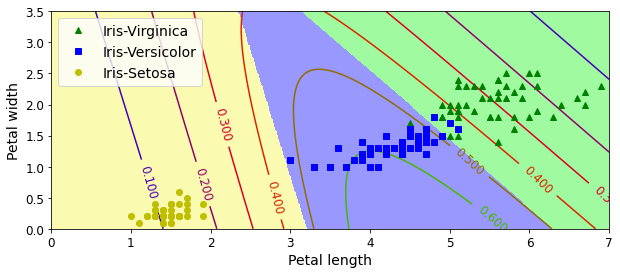

In [138]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

logits = X_new_with_bias.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

And now let's measure the final model's accuracy on the test set:

In [139]:
logits = X_test.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_test)
accuracy_score

0.9333333333333333

Our perfect model turns out to have slight imperfections. This variability is likely due to the very small size of the dataset: depending on how you sample the training set, validation set and the test set, you can get quite different results. Try changing the random seed and running the code again a few times, you will see that the results will vary.